# Projecting PACE Data onto a Predefined Grid

**Authors:** Skye Caplan (NASA, SSAI) <br>
Last updated: October 8, 2025

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA PACE data.

</div>

[edl]: https://urs.earthdata.nasa.gov/
[oci-data-access]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/notebooks/oci_data_access/

## Summary


This notebook will use `rasterio` and `rioxarray` to project PACE OCI data from the instrument swath onto a defined grid with a given resolution. The process for both 2D and 3D variables will be covered. Utilities to export the data in GeoTIFF format are also explained. Several useful functions summarizing these steps are available throughout the tutorial.

## Learning Objectives

At the end of this notebook you will know how to:

- Open and mask 2D and 3D PACE OCI products
- Define a grid with desired pixel resolution
- Reproject data into defined coordinate reference systems and matching grids

## Contents

1. [Setup](#1.-Setup)
2. [Preparing Data for Regridding: Masking and Dimensions](#2.-Preparing-Data-for-Regridding:-Masking-and-Dimensions)
3. [Projecting Data onto a Defined Grid](#3.-Projecting-Data-onto-a-Defined-Grid)
4. [Exporting Data: GeoTIFF and netCDF](#4.-Exporting-Data:-GeoTIFF-and-netCDF)
5. [About Projecting/Exporting Level-3 Data](#5.-About-Projecting/Exporting-Level-3-Data)

## 1. Setup

Begin by importing all of the packages used in this notebook. Please ensure your environment has the most recent versions of `rioxarray` (>=0.19.0) and `rasterio` (>=1.4.3), as the functionality allowing us to correctly convert PACE Level-2 (L2) files to GeoTIFF is relatively new.

PACE OCI has many data products. This tutorial will use the LANDVI and SFREFL data suites to demonstrate how to regrid both 2- and 3D variables.  

<div class="alert alert-info" role="alert">

Although this tutorial uses land-focused products, these methods will work with any type of 2D or 3D PACE OCI data

</div>

The following cells use `earthaccess` to set and persist your Earthdata login credentials, then search for and download the relevant datasets for two scenes which have some overlap in and around the Great Lakes region of North America. A function for adding features to the plots in this tutorials is also included.

In [1]:
from pathlib import Path

import cartopy
import cartopy.crs as ccrs
import cf_xarray  # noqa: F401
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rioxarray as rio
import xarray as xr
from rasterio.enums import Resampling
from rasterio.crs import CRS

def plot_features(ax, gridline_alpha=1):
    ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.25, alpha=gridline_alpha)
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cartopy.feature.OCEAN, edgecolor="w", linewidth=0.01)
    ax.add_feature(cartopy.feature.LAND, edgecolor="w", linewidth=0.01)
    ax.add_feature(cartopy.feature.LAKES, edgecolor="w", linewidth=0.01)

auth = earthaccess.login(persist=True)

In [2]:
scene = (-100, 38, -82, 48)

sr_result = earthaccess.search_data(
    short_name=["PACE_OCI_L2_SFREFL","PACE_OCI_L2_SFREFL_NRT"],
    bounding_box=scene,
    granule_name="*20240610T184843*V3_1*",
)

vi_result = earthaccess.search_data(
    short_name=["PACE_OCI_L2_LANDVI","PACE_OCI_L2_LANDVI_NRT"],
    bounding_box=scene,
    granule_name="*20250511T175448*V3_1*",
)
results = [sr_result[0], vi_result[0]]
for item in results:
    display(item)

paths = earthaccess.download(results, local_path="data")

Collection: {'ShortName': 'PACE_OCI_L2_SFREFL', 'Version': '3.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 48.97807, 'Longitude': -79.5675}, {'Latitude': 42.939, 'Longitude': -113.57634}, {'Latitude': 20.73453, 'Longitude': -103.25936}, {'Latitude': 25.80754, 'Longitude': -77.61629}, {'Latitude': 48.97807, 'Longitude': -79.5675}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2024-06-10T18:53:43Z', 'BeginningDateTime': '2024-06-10T18:48:43Z'}}
Size(MB): 734.4022789001465
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240610T184843.L2.SFREFL.V3_1.nc']

Collection: {'ShortName': 'PACE_OCI_L2_LANDVI', 'Version': '3.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 61.82116, 'Longitude': -64.34892}, {'Latitude': 54.50572, 'Longitude': -109.46275}, {'Latitude': 38.32485, 'Longitude': -96.23775}, {'Latitude': 44.11908, 'Longitude': -64.77824}, {'Latitude': 61.82116, 'Longitude': -64.34892}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-05-11T17:59:47Z', 'BeginningDateTime': '2025-05-11T17:54:48Z'}}
Size(MB): 60.52827548980713
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250511T175448.L2.LANDVI.V3_1.nc']

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

### Opening the data

Now we'll open the datasets we downloaded above. As mentioned, this tutorial demonstrates regridding with the LANDVI and SFREFL data suites. LANDVI contains 10 vegetation indices, or VIs, and SFREFL contains surface reflectances at 122 wavelengths. More information on PACE products can be found on the [PACE Data Products Table](https://pace.oceansciences.org/data_table.htm). 

The `open_l2()` function combines different groups from within the full PACE L2 file and outputs a dataset including the relevant geophysical variables with latitude, longitude, and wavelength (if applicable) as coordinates. Note that L2 files contain additional information, so please open the file's datatree and explore the rest of the contents as well. The function will work for other PACE datasets as well, such as the AOP suite which includes remote sensing reflectances (Rrs).

In [3]:
def open_l2(fpath):
    """ 
    Opens a PACE L2 file as an xarray dataset, assigning lat/lons (and wavelength, 
        if the dataset is 3D) as coordinates.
    Args:
        fpath - path to a L2 PACE file 
    Returns:
        ds - xarray dataset
    """
    dt = xr.open_datatree(fpath, decode_timedelta=False)
    try:
        ds = xr.merge((
            dt.ds,
            dt["geophysical_data"].to_dataset(),
            dt["sensor_band_parameters"].coords,
            dt["navigation_data"].ds.set_coords(("longitude", "latitude")).coords,
            )
        )
    except:
        ds = xr.merge((
            dt.ds,
            dt["geophysical_data"].to_dataset(),
            dt["navigation_data"].ds.set_coords(("longitude", "latitude")).coords,
            )
        )
    return ds

sr = open_l2(paths[0])
vi = open_l2(paths[1])

We can plot both files in the same figure to see how they overlap.

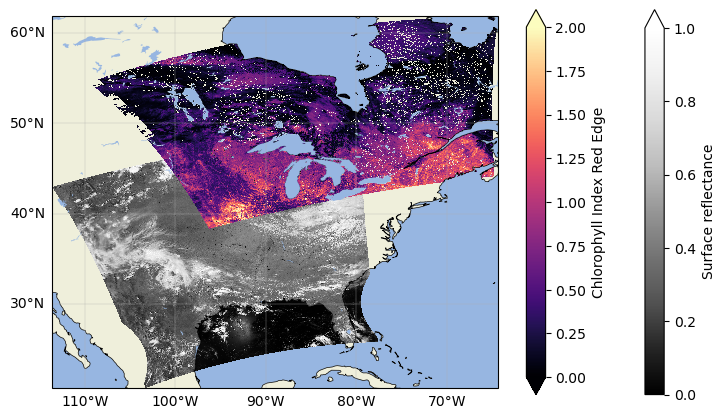

In [5]:
fig, ax = plt.subplots(figsize=(9, 5), subplot_kw={"projection": ccrs.PlateCarree()})
plot_features(ax=ax)
sr.rhos.sel({"wavelength_3d":860}, method="nearest").plot(x="longitude", y="latitude", 
                                                          cmap="Greys_r", vmin=0, vmax=1)
vi.cire.plot(x="longitude", y="latitude", cmap="magma", vmin=0, vmax=2)
plt.title("")
plt.show()

Clearly our two datasets have some overlapping pixels, but the orbits are completely different. Practically, what that means is that none of the latitude/longitude pairs representing the pixel centers would align between granules, and the pixels could even be different sizes because of their location in the swath (edge pixels tend to be wider than those close to nadir). These are intended aspects of the data as L2 PACE files are still in the instrument swath, or in other words, not on any defined or regular grid. This also means, though, that the data are at a finer spatial resolution than the Level 3 mapped datasets that are distributed from PACE.  

Using swath L2 data can make comparing between different satellites, or even two PACE granules from different times, difficult. However, each pixel does have an associated latitude and longitude. With those coordinates, we can project these L2 datasets onto the same grid to make our analyses more intuitive and fair.

## 2. Preparing Data for Regridding: Masking and Dimensions

Before we get to the actual regridding of our data, we need to make sure the datasets are properly prepared. 

### Masking
In the plot above, there are clearly cloudy pixels in both the surface reflectance (`rhos`) and the VIs. L2 PACE data includes the `l2_flags` variable, which keeps track of quality flags for each pixel in the dataset. The `cf_xarray` package will allow us to make use of those flags and mask out any low-quality data we see fit. A list of all possible flags can be found [here](https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/).

In [6]:
def mask_ds(ds, flag="CLDICE", reverse=False):
    """
    Mask a PACE dataset for an L2 flag. Default is to mask for clouds
    Args:
        ds - xarray dataset containing "l2_flags" variable
        flag - l2 flag to mask for (see https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/)
        reverse - keep only pixels with the desired flag. Default is False. E.g., use the
                  "LAND" flag to mask water pixels. 
    Returns:
        Masked dataset
    """
    if ds["l2_flags"].cf.is_flag_variable:
        if reverse==False:
            return ds.where(~(ds["l2_flags"].cf == flag))
        else:
            return ds.where((ds["l2_flags"].cf == flag))
    else:
        print("l2_flags not recognized as flag variable")

sr_masked = mask_ds(sr)
vi_masked = mask_ds(vi)

Plot the data again to see the masked datasets:

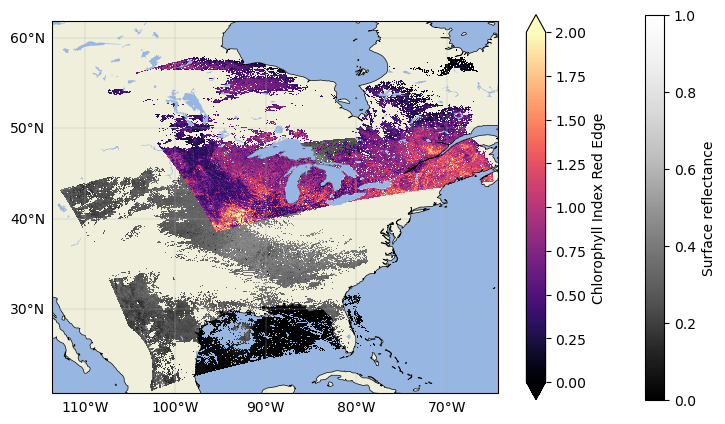

In [7]:
fig, ax = plt.subplots(figsize=(9, 5), subplot_kw={"projection": ccrs.PlateCarree()})
plot_features(ax=ax)
sr_masked.rhos.sel({"wavelength_3d":860}, method="nearest").plot(x="longitude", y="latitude", 
                                                          cmap="Greys_r", vmin=0, vmax=1)
vi_masked.cire.plot(x="longitude", y="latitude", cmap="magma", vmin=0, vmax=2)
plt.title("")
plt.show()

Now the data should be clear of any pixels flagged as cloudy! Repeat that step with other flags if you want to exclude other potential quality indicators. 

### Dimensions

The final piece before we reproject goes back to the dimensions of our datasets. Let's print out those dimensions to illustrate their differences:

In [8]:
print(f"Surface reflectance dimensions: {list(sr_masked.rhos.dims)}")
print(f"Vegetation index dimensions: {list(vi.dims)}")

Surface reflectance dimensions: ['number_of_lines', 'pixels_per_line', 'wavelength_3d']
Vegetation index dimensions: ['number_of_lines', 'pixels_per_line']


For `rhos` we have dimensions `('number_of_lines', 'pixels_per_line', 'wavelength_3d')` corresponding to (Y, X, Z). Trying to reproject the data with that dimension order will cause an `InvalidDimensionError` from `rioxarray` because the package expects 3D variables to have dimensions ordered (Z, Y, X), or in our dataset's terms, `('wavelength_3d', 'number_of_lines', 'pixels_per_line')`. This is also how many GIS software programs, such as [QGIS](https://qgis.org/), expect datasets to be ordered. 

To put `rhos` in the correct dimensional order, we'll use `.transpose()` to transpose the data so that the wavelength dimension, `wavelength_3d`, is first. For the reprojection, we also have to drop the `l2_flags` variable from this dataset since `rioxarray` does not support reprojecting mixed-dimension variables in the same dataset. Finally, we'll also update the attributes with those from the full dataset to retain some relevant information that would get lost by just selecting the `rhos` variable.

The VI dataset is 2D and in the form (Y, X), which is what the package expects, so we don't have to transpose the data in any way. We will drop `l2_flags` from the VI dataset for consistency. We also don't need to update `attrs` because we're dropping a variable from the full dataset rather than selecting a single variable with its own attributes, so the information stays. 

<div class="alert alert-warning" role="alert">

Because we have to drop the `l2_flags` variable, all masking should be done before you transpose and grid your data

</div>

In [8]:
# Selecting only rhos from the masked dataset, and transposing
sr_masked = sr_masked["rhos"].transpose("wavelength_3d", ...)
sr_masked.attrs.update(sr.attrs)

# Explicitly dropping l2_flags from vi_masked
vi_masked = vi_masked.drop_vars("l2_flags")

## 3. Projecting Data onto a Defined Grid

We can now move on to the actual gridding of our data. We'll do this by defining a grid with the same parameters for both datasets, and applying that grid to each granule separately (so you don't end up with a grid full of `nan`s). There are several things we'll need to know in order to get our two granules on the same grid:
1. The bounds of our desired grid
3. Our desired resolution for the data
4. The CRS of our data, and the one we want our data projected into

All of these things will go into building an affine transform, which is a sequence of six coefficients that tell the array how to restructure itself into the grid we're building.

Since we prepared the masked rasters we're using for this demonstration above, we have pretty much all of we need to create an affine transform. We'll define the `grid_data` function to take in our datasets and desired resolution, create the necessary grid, and project the data onto it.

In [9]:
def grid_data(src, resolution, dst_crs="epsg:4326", resampling=Resampling.nearest):
    """
    Reproject a L2 dataset to match an input grid. Makes sure 3D variables are
        in (Z, Y, X) dimension order, and all variables have spatial dims/crs 
        assigned.
    Args:
        src - an xarray dataset or dataarray to reproject
        resolution - resolution of the output grid, in dst_crs units
        dst_crs - CRS of the output data
        resampling - resampling method (see rasterio.enums)
    Returns:
        dst - projected xr dataset
    """
    if (len(list(src.dims)) == 3) and (list(src.dims)[0] != "wavelength_3d"):
        src = src.transpose("wavelength_3d", ...)
    src = src.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    src = src.rio.write_crs("epsg:4326")

    # Calculating the default affine transform
    defaults = rasterio.warp.calculate_default_transform(
        src.rio.crs,
        dst_crs,
        src.rio.width,
        src.rio.height,
        left=src.attrs["geospatial_lon_min"],
        bottom=src.attrs["geospatial_lat_min"],
        right=src.attrs["geospatial_lon_max"],
        top=src.attrs["geospatial_lat_max"],
    )
    # Aligning that transform to our desired resolution
    transform, width, height = rasterio.warp.aligned_target(*defaults, resolution)
    
    dst = src.rio.reproject(
        dst_crs=dst_crs,
        shape=(height, width),
        transform=transform,
        src_geoloc_array=(
            src["longitude"],
            src["latitude"],
        ),
        nodata=np.nan,
        resample=resampling,
    )
    dst["x"] = dst["x"].round(9)
    dst["y"] = dst["y"].round(9)
    
    return dst.rename({"x":"longitude", "y":"latitude"})

resolution = (0.015, 0.015)

sr_gridded = grid_data(sr_masked, resolution)
vi_gridded = grid_data(vi_masked, resolution)

sr_gridded.rio.transform()

Affine(0.015, 0.0, -113.58,
       0.0, -0.015, 48.99)

Both our datasets should now be on an aligned grid. We can take a look at one of their transforms and see that it consists 6 numbers which represent:
- A[0] = x-component of the pixel size, in this case 0.015 degrees, which is ~1.6 km at the equator
- A[1] = rotation of the pixel around the x-axis (this is 0 for north-up images)
- A[2] = x coordinate (or longitude, here) of the upper left corner of the top left pixel (i.e., the westernmost pixel)
- A[3] = rotation of the pixel around the y-axis (this is 0 for north-up images)
- A[4] = y-component of the pixel size, in this case 0.015 degrees. Negative because rows in netCDF format (and GeoTIFF, and many others) increase downward, while a real-world y-axis would increase upward.
- A[5] = y coordinate (or latitude, here) of the upper left corner of the top left pixel (i.e., the northermost pixel)

We can print out the 2nd dataset's transform as well to compare:

In [10]:
vi_gridded.rio.transform()

Affine(0.015, 0.0, -109.47,
       0.0, -0.015, 61.83)

The numbers in our affine transform are mostly the same, except for A[2] and A[5] which correspond to the origin of the granule. We expect this behaviour because we're working with two different granules that have varying top left corner coordinates. However, they should now both have pixels with the same resolution and centers that align where they overlap. 

You can now do computations between the datasets knowing each pixel is aligned in space. We can visually check this is true by plotting an area of overlap with the pixel boundaries highlighted, seeing that overlap entirely. Gridding also makes subsetting for a given scene easier by leaving us with 1D lat/lon arrays, which means you could also compare the lat/lon pairs directly by printing out the arrays.

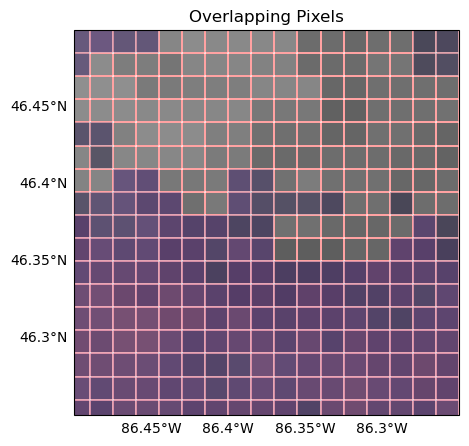

In [12]:
sr_sub = sr_gridded.sel({"longitude": slice(scene[0], scene[2]),
                         "latitude": slice(scene[3], scene[1])})
vi_sub = vi_gridded.sel({"longitude": slice(scene[0], scene[2]),
                         "latitude": slice(scene[3], scene[1])})

fig, ax = plt.subplots(figsize=(9, 5), sharey=True, subplot_kw={"projection": ccrs.PlateCarree()})
plot_features(ax=ax, gridline_alpha=0)
sr_sub.sel({"wavelength_3d":860}, method="nearest").plot(cmap="Greys_r", vmin=0, vmax=1,
                                                         linewidth=0.05, edgecolors="red", add_colorbar=False)
vi_sub.cire.plot(cmap="magma", vmin=0, vmax=3, linewidth=0.05, edgecolors="white", add_colorbar=False, alpha=0.4)
ax.set_extent((-86.5, -86.25, 46.25, 46.5))
plt.title("Overlapping Pixels")
plt.show()

Let's plot the whole overlapping area, just to fully visualize our scene:

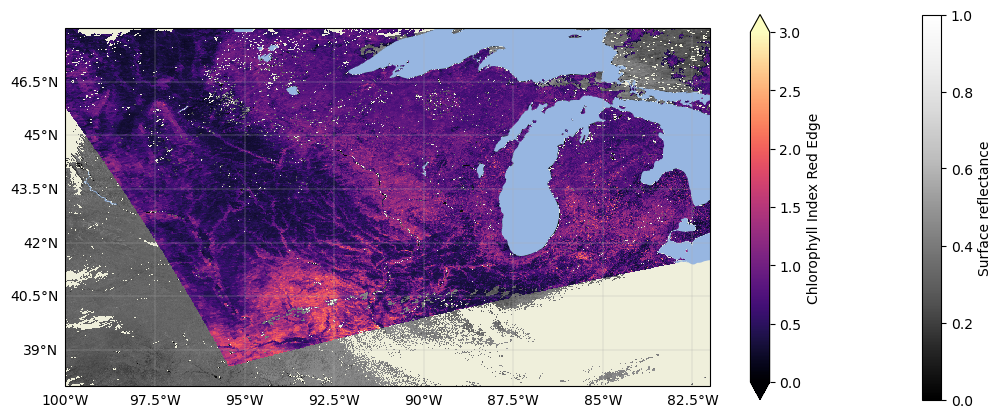

In [12]:
fig, ax = plt.subplots(figsize=(13, 5), subplot_kw={"projection": ccrs.PlateCarree()})
plot_features(ax=ax)
sr_sub.sel({"wavelength_3d":860}, method="nearest").plot(cmap="Greys_r", vmin=0, vmax=1)
vi_sub.cire.plot(cmap="magma", vmin=0, vmax=2)
plt.title("")
plt.show()

And now our data are fully gridded and comparable! You could go straight into your analysis from here, but if you don't want to have to repeat this process for your favourite granules every time you work with them, it is useful to export the data to your favourite file format. 

## 4. Exporting Data: GeoTIFF and netCDF

### Cloud Optimized GeoTIFFs (COGs)

First, we export to a Cloud Optimized GeoTIFF, or a COG, using the "COG" driver with applicable profile options. COGs are a subset of GeoTIFFs which have been optimized to work in cloud environments. If you are not working in the cloud, you don't have to worry, as COGs are backwards compatible with normal GeoTIFFs. That is, any software that can be used to analyze a GeoTIFF can also be used with COGs. For more information on the COG format, please see the [cogeo website](https://cogeo.org/). There is also a very useful plug in for rasterio called `rio-cogeo` for creating/validating COGs, documentation for which can be found [here](https://cogeotiff.github.io/rio-cogeo/).

We create our files by building a profile from the destination datasets (`sr_sub` or `vi_sub`, in this case) and using the `rio.to_raster()` method. Each of the profile options is necessary for the format conversion, but can be changed to user preference as needed. For example, if you prefer a different `nodata` value, substitute the value you'd like to instead in the dictionaries below.

In [30]:
sr_dst_name = Path(paths[0]).with_suffix(".tif")
profile = {
    "driver": "COG",
    "width": sr_gridded.shape[2],
    "height": sr_gridded.shape[1],
    "count": sr_gridded.shape[0],
    "crs": sr_gridded.rio.crs,
    "dtype": sr_gridded.dtype,
    "transform": sr_gridded.rio.transform(),
    "compress": "lzw",
    "nodata": np.nan,
    "interleave":"BAND",
    "tiled":"YES",
    "blockxsize": "512", "blockysize": "512",
}
sr_sub.rio.to_raster(sr_dst_name, **profile)

vi_dst_name = Path(paths[1]).with_suffix(".tif")
profile = {
    "driver": "COG",
    "width": vi_gridded["cire"].shape[1],
    "height": vi_gridded["cire"].shape[0],
    "count": 10,
    "crs": vi_gridded.rio.crs,
    "dtype": vi_gridded["cire"].dtype,
    "transform": vi_gridded.rio.transform(),
    "compress": "lzw",
    "nodata": np.nan,
    "interleave":"BAND",
    "tiled":"YES",
    "blockxsize": "512", "blockysize": "512",
}
vi_sub.rio.to_raster(vi_dst_name, **profile)

The files should be successfully exported as COGs. To make a nice quick true colour image in your program of choice, you can set R = 655 nm (band 60), G = 555 nm (band 42), and B = 470 nm (band 25).

### NetCDFs

To export as a netCDF, all you need to do is use `xarray`'s `to_netcdf()` function. Uncomment the lines in the cell below to begin the export:

In [ ]:
#sr_sub.to_netcdf("PACE_OCI.20240610T184843.SFREFL_gridded.nc")
#vi_sub.to_netcdf("PACE_OCI.20240610T184843.LANDVI_gridded.nc")

## 5. About Projecting/Exporting Level-3 Data

Level-3 Mapped (L3M) PACE data is already mapped to a Plate Carrée projection - in other words, unless you want the data in another projection, you don't need to reproject as we did for the L2 data above. In order to convert these files from NetCDF to GeoTIFF, all you need is to transpose the datasets as necessary and assign their CRS.

In [ ]:
# Example search for pulling a specific grnaule
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_LANDVI",
    granule_name="PACE_OCI.20240601_20240630.L3m.MO.LANDVI.V3_1.0p1deg.nc",
)
l3_path = earthaccess.download(results, local_path="data")

if "SFREFL" in str(l3_path[0]):
    ds = xr.open_dataset(l3_path[0]).rhos.transpose("wavelength", ...)
elif "LANDVI" in str(l3_path[0]):
    ds = xr.open_dataset(l3_path[0]).drop_vars("palette")

ds = ds.rio.write_crs("epsg:4326")
ds.rio.to_raster(Path(l3_path[0]).with_suffix(".tif"), driver="COG")

<div class="alert alert-info" role="alert">

You have completed the notebook on gridding and format conversion of PACE OCI L2 data. We suggest looking at the notebook on "Machine Learning with Satellite Data" to explore some more advanced analysis methods.

</div>

[back to top](#Contents)